In [39]:
import numpy as np 
import pandas as pd 

from datetime import datetime
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [40]:
# import Dataset
df = pd.read_csv('IOT-temp.csv', parse_dates=['noted_date'])
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,2018-08-12 09:30:00,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,2018-08-12 09:30:00,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,2018-08-12 09:29:00,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,2018-08-12 09:29:00,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,2018-08-12 09:29:00,31,In


In [41]:
##DATA PROCESSING


In [43]:
##REMOVING USELESS COLUMNS
df['room_id/id'].value_counts()

Room Admin    97606
Name: room_id/id, dtype: int64

In [44]:
# dropping columns
cols_drop = ['id', 'room_id/id']
df = df.drop(cols_drop, axis=1)

In [45]:
##TABLE RESHAPE
print("the dataset has shape = {}".format(df.shape))

the dataset has shape = (97606, 3)


In [46]:
df.describe()
# duplicate rows have been dropped

,temp
count,97606.000000
mean,35.053931
std,5.699825
min,21.000000
25%,30.000000
50%,35.000000
75%,40.000000
max,51.000000


In [47]:
#Here I want to round time of measurement up to hours. After I will get information about mean temperature for each measure hour for inside and outside. It will allow to know about relation between Inside and outside in the moment.
# building new features for time stamp.
df['measure_hour'] = df.noted_date.apply(lambda x:datetime.strftime(x,'%Y-%m-%d %H:00:00'))

In [48]:
#Here I will get table with hour of measurement as index, and mean valuse of inside and outside temperatures in this hour. After I will drop all rows with at leas one NaN value.
data = df.groupby(['measure_hour','out/in']).temp.mean().reset_index()
data = data.pivot(index = 'measure_hour',columns = 'out/in', values = 'temp').reset_index().dropna()
data.head()

out/in,measure_hour,In,Out
0,2018-01-11 00:00:00,32.000000,40.071429
2,2018-01-11 02:00:00,31.750000,38.428571
3,2018-01-11 03:00:00,30.444444,40.666667
4,2018-01-11 04:00:00,30.000000,42.200000
5,2018-01-11 05:00:00,30.000000,43.875000


Text(0.5, 0, 'Temperature')

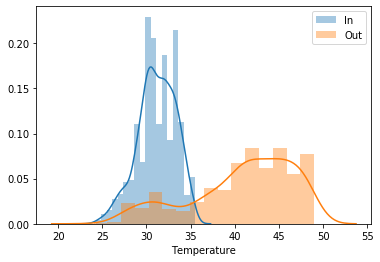

In [49]:
##VISUALIZATION
fig, ax = plt.subplots(figsize = (6,4))
g = sns.distplot(data.In, label = 'In')
g = sns.distplot(data.Out, label = 'Out')
plt.legend()
g.set_xlabel('Temperature')

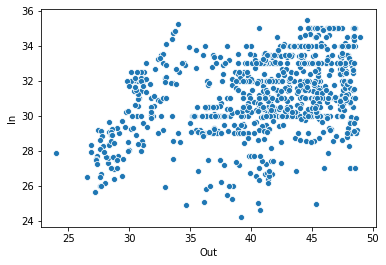

In [50]:
#And our goal - relationship between inside and outside temperatures
sns.scatterplot(x =data.Out, y = data.In)
#We can make a guess that people turn on the conditioner if outside temperature in higher than 35. So, can say, that inside temperature is in interval [28;35] if outside temperature is higher than 35. Lets take a look on piece of data with outside temperature above 35

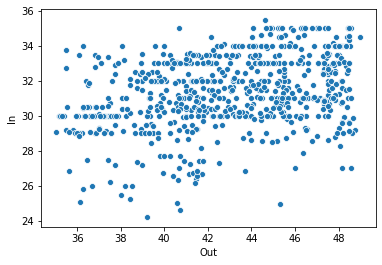

In [51]:
sns.scatterplot(x =data[data.Out>35].Out, y = data[data.Out>35].In)




#But we can see some obvious dependense inside of outside for outisde in interval [25;35]. We defenetly can say that there is no obvious dependence

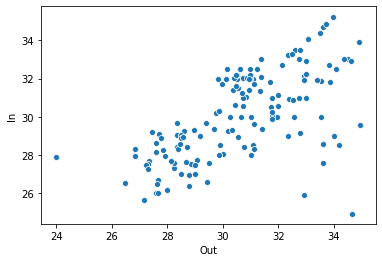

In [52]:
sns.scatterplot(x =data[data.Out<=35].Out, y = data[data.Out<=35].In)


#So, after removing from set values with outside temperature above 35, we can see linear dependence. And we can use linear regression to predict inside temperature with known outside value.

In [53]:
linear = data[(pd.notna(data.Out))&(pd.notna(data.In)) & (data.Out<35)]

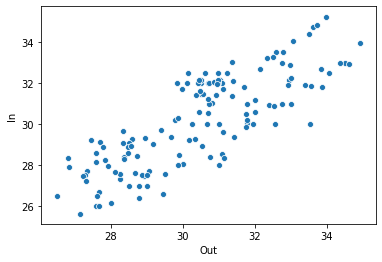

In [54]:
#WILL REMOVE SOME OUTLINERS HERE:
#removing oultliers
linear = linear.drop(index = linear[((linear.Out>32)&(linear.In<30)|(linear.Out<25))].index, axis = 0)
sns.scatterplot(x = linear.Out, y = linear.In)

In [55]:
#Linear regression building
model = LinearRegression()
model.fit(linear[['Out']],linear.In)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

0.8934565680813318 3.0031835176757795


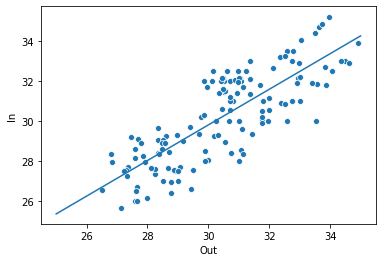

In [56]:
k,b = model.coef_[0],model.intercept_
print(k,b)
sns.scatterplot(x = linear.Out, y = linear.In)
reg_line = np.linspace(25,35,100)
plt.plot(reg_line, reg_line*k + b)

In [ ]:
##So, I would describe the relationship between inside and outside temperatures like this:

#Inside(Outside)=0.89∗Outside+3, if Outside∈[25,35],Inside(Outside)∈[28;35],if Outside∈(35;∞)